# Preview: Progressively applying safeguards for tighter and less conservative corrections

The `compression-safeguards` are implemented to use one-pass (instead of iterative) algorithms and to make use of vectorisation over arrays. As a consequence, the corrections for all elements are computed simultaneously. While this makes no difference for pointwise safeguards, it means that stencil safeguards have to make conservative assumptions about how neighbouring elements can affect each other in order to guarantee that their combined errors do not violate any user safety requirements. Progressively applying the safeguards to make less conservative assumptions and produce tighter corrections by giving the safeguards knowledge of previously corrected elements when computing the corrections for the next elements. While the `compression-safeguards` currently do not implement progressive corrections, this notebook sketched how they might work, by extending and patching the package where necessary.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
import re
from collections.abc import Collection, Mapping, Set
from itertools import product
from pathlib import Path
from typing import ClassVar

import earthkit.plots
import matplotlib as mpl
import numpy as np
import xarray as xr
from matplotlib.patches import Patch
from numcodecs_safeguards.lossless import Lossless
from typing_extensions import override

from compression_safeguards import SafeguardKind, Safeguards
from compression_safeguards.safeguards._qois import StencilQuantityOfInterest
from compression_safeguards.safeguards._qois.expr.typing import F, Ns, Ps
from compression_safeguards.safeguards.abc import Safeguard
from compression_safeguards.safeguards.pointwise.abc import PointwiseSafeguard
from compression_safeguards.safeguards.stencil.qoi.eb import (
    StencilQuantityOfInterestErrorBoundSafeguard,
)
from compression_safeguards.utils.bindings import Bindings, Parameter
from compression_safeguards.utils.intervals import Interval, IntervalUnion, Lower, Upper
from compression_safeguards.utils.typing import JSON, C, S, T

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00")
ERA5_U.shape

(1, 721, 1440)

In [4]:
qoi = SafeguardKind.qoi_eb_stencil.value(
    qoi="sum(X) / size(X)",  # box mean
    neighbourhood=[
        dict(axis=1, before=2, after=2, boundary="wrap"),
    ],
    type="abs",
    eb=0.1,
)
qoi._qoi_expr

(X[0] + X[1] + X[2] + X[3] + X[4]) / 5

In [5]:
def compute_mean_wind_u(ERA5_U: xr.DataArray) -> xr.DataArray:
    ERA5_U_mean = ERA5_U.copy(
        data=qoi.evaluate_qoi(ERA5_U.values, late_bound=Bindings.empty())
    )
    ERA5_U_mean.attrs.update(long_name=f"mean {ERA5_U.long_name}")
    return ERA5_U_mean

In [6]:
ERA5_U_mean = compute_mean_wind_u(ERA5_U)

In [7]:
correction_codec = Lossless().for_safeguards
correction_codec

CodecStack(PickBestCodec(HuffmanCodec(), CodecStack(BinaryDeltaCodec(), HuffmanCodec())), Zstd(level=3))

In [8]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [9]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [10]:
def plot_mean_wind_u(
    my_ERA5_U: xr.DataArray,
    cr,
    chart,
    title,
    span,
    mean=True,
    error=False,
    qoi_stencil=None,
    correction=None,
):
    import copy

    ERA5_U_pick = ERA5_U_mean if mean else ERA5_U
    my_ERA5_U_pick = compute_mean_wind_u(my_ERA5_U) if mean else my_ERA5_U

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_U_pick - ERA5_U_pick).compute()

        err_U_pick = np.amax(np.abs(my_ERA5_U_pick - ERA5_U_pick))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        da = my_ERA5_U_pick

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(-span, span, 22))
    style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
    style._colors = "coolwarm" if error else style._colors

    extend_left = np.nanmin(da) < -span
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        if mean:
            chart.title(
                f"{title}\n"
                + rf"$L_{{{{\infty}}}}(\overline{{{{\hat{{{{u}}}}}}}})$={err_U_pick:.02}"
            )
        else:
            chart.title("\n" + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_U_pick:.02}")
    else:
        chart.title(f"{title}\n")

    if error and mean:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(da.values.flatten(), range=(-span, span), bins=21)
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    cax = cb.ax.inset_axes([0.0, 1.25 if qoi_stencil is None else 3.5, 1.0, 1.0])
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(-span, span)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

    stackcolors = np.array(mpl.color_sequences["Pastel1"])[[2, 3, 4, 0, 1, 6, 7]]

    if qoi_stencil is not None:
        cax2 = cb.ax.inset_axes([0.0, 1.25, 1.0, 2.0])
        counts_stacked = []
        for i in product(*[range(s) for s in qoi_stencil]):
            progindex = tuple(
                slice(None) if s == 1 else slice(j, None, s)
                for j, s in zip(i, qoi_stencil)
            )
            counts2, _bins2 = np.histogram(
                da.values[progindex].flatten(), range=(-span, span), bins=21
            )
            counts_stacked.append(counts2)
        counts_stacked = np.stack(counts_stacked, axis=0)
        counts_stacked = counts_stacked / np.sum(counts_stacked, axis=0)
        for i in range(len(counts_stacked)):
            cax2.bar(
                midpoints,
                counts_stacked[i],
                bottom=counts_stacked[:i].sum(0),
                width=(bins[-1] - bins[0]) / len(counts),
                color=stackcolors[i],
            )
        cax2.set_xlim(-span, span)
        cax2.set_xticks([])
        cax2.set_yticks([])
        cax2.spines[:].set_visible(False)

        if error and not mean:
            legend_elements = []
            qoi_stencil_indices = list(product(*[range(s) for s in qoi_stencil]))
            for k, i in enumerate(qoi_stencil_indices):
                progindex = tuple(
                    slice(None) if s == 1 else slice(j, None, s)
                    for j, s in zip(i, qoi_stencil)
                )
                if len(qoi_stencil_indices) != 1:
                    correction_encoded = correction_codec.encode(
                        np.ascontiguousarray(correction[progindex])
                    )
                    correction_cr = (
                        ERA5_U[progindex].nbytes / np.array(correction_encoded).nbytes
                    )
                legend_elements.append(
                    Patch(
                        facecolor=stackcolors[k],
                        edgecolor="grey",
                        label="one shot"
                        if len(qoi_stencil_indices) == 1
                        else f"#{k + 1}: x {np.round(correction_cr, 2)} ({np.round(np.mean(correction != 0) * 100, 2)}%)",
                    )
                )
            chart.ax.legend(handles=legend_elements, loc="lower center", ncol=2)

In [11]:
sg = Safeguards(safeguards=[qoi])

In [12]:
ERA5_U_prediction = np.zeros_like(ERA5_U.values)

In [13]:
ERA5_U_sg_correction = sg.compute_correction(ERA5_U.values, ERA5_U_prediction)
ERA5_U_sg = sg.apply_correction(ERA5_U_prediction, ERA5_U_sg_correction)

assert sg.check(ERA5_U.values, ERA5_U_sg)

ERA5_U_sg_encoded = correction_codec.encode(ERA5_U_sg_correction)
ERA5_U_sg_cr = ERA5_U.nbytes / np.array(ERA5_U_sg_encoded).nbytes

In [14]:
PROGRESSIVE_MASK: Parameter = Parameter("$progmask")
PROGRESSIVE_PREDICTION: Parameter = Parameter("$progpred")


class ProgressiveSafeguard(PointwiseSafeguard):
    __slots__: tuple[str, ...] = ()

    kind: ClassVar[str] = "progressive"

    def __init__(self) -> None:
        pass

    @property
    @override
    def late_bound(self) -> Set[Parameter]:
        return frozenset([PROGRESSIVE_MASK, PROGRESSIVE_PREDICTION])

    @override
    def check_pointwise(
        self,
        data: np.ndarray[S, np.dtype[T]],
        decoded: np.ndarray[S, np.dtype[T]],
        *,
        late_bound: Bindings,
    ) -> np.ndarray[S, np.dtype[np.bool]]:
        return np.ones_like(data, dtype=np.bool)  # type: ignore

    @override
    def compute_safe_intervals(
        self,
        data: np.ndarray[S, np.dtype[T]],
        *,
        late_bound: Bindings,
    ) -> IntervalUnion[T, int, int]:
        mask = late_bound.resolve_ndarray_with_lossless_cast(
            PROGRESSIVE_MASK, data.shape, np.dtype(np.bool)
        )
        prediction = late_bound.resolve_ndarray_with_lossless_cast(
            PROGRESSIVE_PREDICTION, data.shape, data.dtype
        )

        valid = Interval.full_like(data)
        Lower(prediction.flatten()) <= valid[mask.flatten()] <= Upper(
            prediction.flatten()
        )

        validu = valid.into_union()

        # override the class of the valid interval union with one that accepts
        #  non-overlap with the data for elements that have already been
        #  corrected,
        # which is required to create a safeguard that forces the existing
        #  corrections to be recreated
        class MyIntervalUnion(IntervalUnion):
            __slots__ = ()

            def contains(
                self, other: np.ndarray[S, np.dtype[T]]
            ) -> np.ndarray[S, np.dtype[np.bool]]:
                is_contained: np.ndarray[S, np.dtype[np.bool]] = super().contains(other)

                if np.array_equal(other, data, equal_nan=True):
                    is_contained |= mask

                return is_contained

        validu.__class__ = MyIntervalUnion

        return validu

    @override
    def get_config(self) -> dict[str, JSON]:
        return dict(kind=type(self).kind)

In [15]:
def rewrite_stencil_qoi_eb_safeguard_into_progressive(
    qoi: StencilQuantityOfInterestErrorBoundSafeguard,
) -> Collection[Safeguard]:
    # extract the fully-resolved QoI expression, in text representation
    qoi_expr_repr = repr(qoi._qoi_expr)

    # replace mentions of the data stencil X with where(mask, prediction, X)
    #  to fill in the already-corrected prediction for elements where the
    #  correction has already been produced
    qoi_expr_progressive_repr = re.sub(
        r"X\[([^]]+)\]",
        rf'where(C["{PROGRESSIVE_MASK}"][\1], C["{PROGRESSIVE_PREDICTION}"][\1], X[\1])',
        qoi_expr_repr,
    )

    # create a new QoI expression with the progressive QoI
    qoi_progressive_expr = StencilQuantityOfInterestErrorBoundSafeguard(
        qoi=qoi_expr_progressive_repr,
        **{k: v for k, v in qoi.get_config().items() if k not in ("kind", "qoi")},
    )._qoi_expr

    # override (a copy of) the QoI's class with one that uses the progressive
    #  QoI, but only for deriving corrections, and thus requires the additional
    #  late-bound constants for progressive corrections
    class MyStencilQuantityOfInterest(StencilQuantityOfInterest):
        __slots__ = ()

        @property
        def late_bound_constants(self) -> Set[Parameter]:
            return qoi_progressive_expr.late_bound_constants

        @np.errstate(divide="ignore", over="ignore", under="ignore", invalid="ignore")
        def compute_data_bounds(
            self,
            qoi_lower: np.ndarray[Ps, np.dtype[F]],
            qoi_upper: np.ndarray[Ps, np.dtype[F]],
            Xs: np.ndarray[Ns, np.dtype[F]],
            late_bound: Mapping[Parameter, np.ndarray[Ns, np.dtype[F]]],
        ) -> tuple[np.ndarray[Ns, np.dtype[F]], np.ndarray[Ns, np.dtype[F]]]:
            return qoi_progressive_expr.compute_data_bounds(
                qoi_lower, qoi_upper, Xs, late_bound
            )

    qoi_progressive = StencilQuantityOfInterestErrorBoundSafeguard(
        **{k: v for k, v in qoi.get_config().items() if k not in ("kind",)}
    )
    qoi_progressive._qoi_expr.__class__ = MyStencilQuantityOfInterest

    # combine the progressive safeguard, which takes care of recreating already
    #  computed corrections, with the now-progressive QoI, which takes these
    #  already computed corrections into account to produce tighter corrections
    return (ProgressiveSafeguard(), qoi_progressive)


sg_progressive = Safeguards(
    safeguards=[*rewrite_stencil_qoi_eb_safeguard_into_progressive(qoi)]
)

In [16]:
# compute the total stencil size over which we can progressively apply the
#  safeguards
qoi_stencil = []

for axis in qoi.compute_check_neighbourhood_for_data_shape(ERA5_U.shape):
    max_stencil = 1

    for b, s in axis.items():
        max_stencil = max(max_stencil, s.before + 1 + s.after)

    qoi_stencil.append(max_stencil)

qoi_stencil

[1, 5, 1]

In [17]:
def compute_progressive_correction(
    data: np.ndarray[S, np.dtype[T]],
    prediction: np.ndarray[S, np.dtype[T]],
) -> np.ndarray[S, np.dtype[C]]:
    progressive_mask = np.zeros(data.shape, dtype=np.bool)
    progressive_correction = np.empty(
        data.shape, sg.correction_dtype_for_data(data.dtype)
    )
    progressive_prediction = np.empty_like(data)

    # instead of applying the safeguards progressively one element at a time,
    # apply them to the i'th element of non-overlapping windows of the same size as
    #  the stencil
    # this gives (asymptotically) the same extra knowledge when the stencil is
    #  symmetric, but one element per axis less knowledge when it is asymmetric
    for i in product(*[range(s) for s in qoi_stencil]):
        progindex = tuple(
            slice(None) if s == 1 else slice(j, None, s) for j, s in zip(i, qoi_stencil)
        )

        # compute and apply the correction
        progressive_correction_partial = sg_progressive.compute_correction(
            data,
            prediction,
            late_bound={
                PROGRESSIVE_MASK: progressive_mask,
                PROGRESSIVE_PREDICTION: progressive_prediction,
            },
        )
        progressive_corrected_partial = sg_progressive.apply_correction(
            prediction, progressive_correction_partial
        )

        # save the correction and corrected elements for the part of the stencil
        #  that we are (re-)computing, then update the mask to reflect that these
        #  elements have now already been corrected
        progressive_correction[progindex] = progressive_correction_partial[progindex]
        progressive_prediction[progindex] = progressive_corrected_partial[progindex]
        progressive_mask[progindex] = True

    return progressive_correction

In [18]:
# apply the combined correction using the non-progressive safeguard
ERA5_U_sg_progressive_correction = compute_progressive_correction(
    ERA5_U.values, ERA5_U_prediction
)
ERA5_U_sg_progressive = sg.apply_correction(
    ERA5_U_prediction, ERA5_U_sg_progressive_correction
)

assert sg.check(ERA5_U.values, ERA5_U_sg_progressive)

ERA5_U_sg_progressive_encoded = correction_codec.encode(
    ERA5_U_sg_progressive_correction
)
ERA5_U_sg_progressive_cr = (
    ERA5_U.nbytes / np.array(ERA5_U_sg_progressive_encoded).nbytes
)

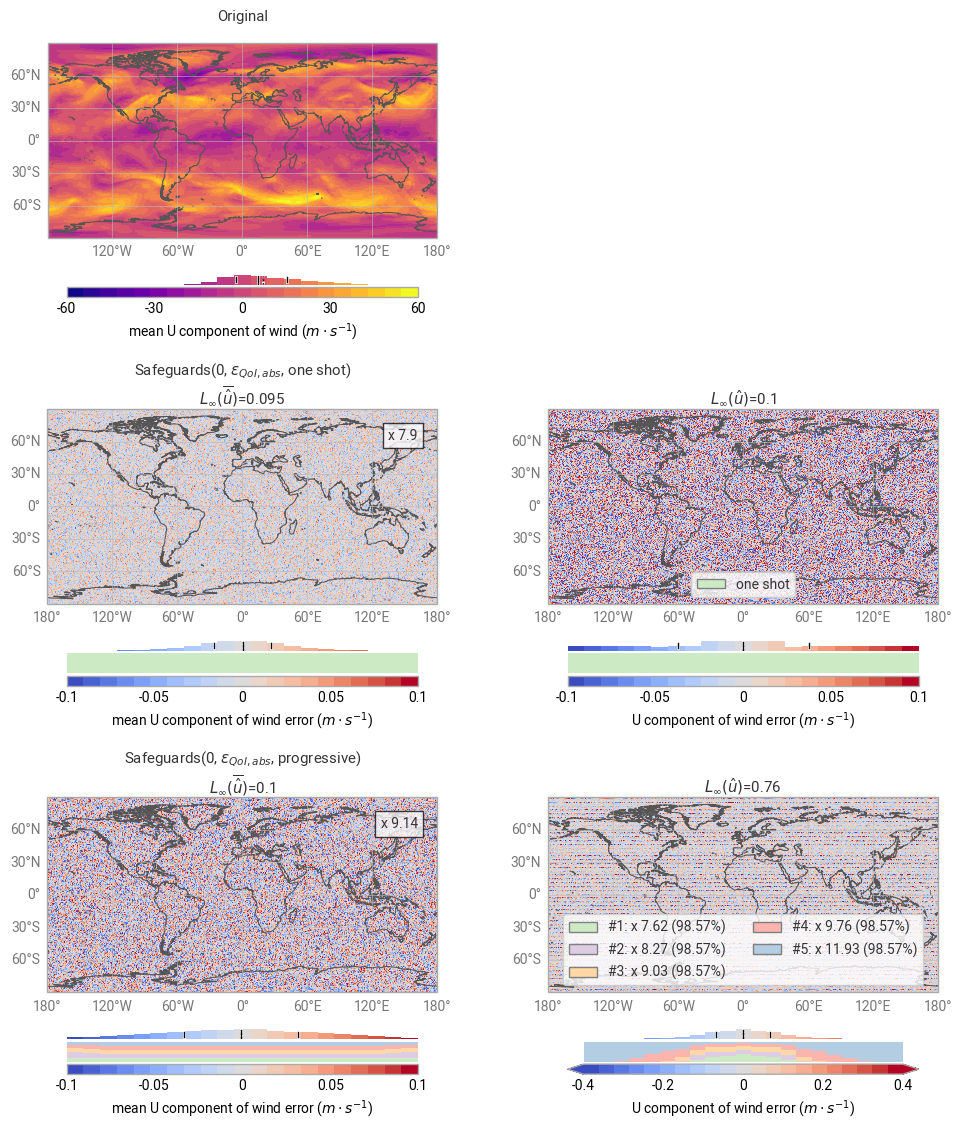

In [19]:
fig = earthkit.plots.Figure(
    size=(10, 11),
    rows=3,
    columns=2,
    hspace=0.1,
)

plot_mean_wind_u(ERA5_U, 1.0, fig.add_map(0, 0), "Original", span=60)

plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg),
    ERA5_U_sg_cr,
    fig.add_map(1, 0),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$, one shot)",
    span=0.1,
    error=True,
    qoi_stencil=[1, 1, 1],
)
plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg),
    ERA5_U_sg_cr,
    fig.add_map(1, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$, one shot)",
    span=0.1,
    error=True,
    mean=False,
    qoi_stencil=[1, 1, 1],
    correction=ERA5_U_sg_correction,
)

plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_progressive),
    ERA5_U_sg_progressive_cr,
    fig.add_map(2, 0),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$, progressive)",
    span=0.1,
    error=True,
    qoi_stencil=qoi_stencil,
)
plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_progressive),
    ERA5_U_sg_progressive_cr,
    fig.add_map(2, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$, progressive)",
    span=0.4,
    error=True,
    mean=False,
    qoi_stencil=qoi_stencil,
    correction=ERA5_U_sg_progressive_correction,
)

fig.show()